<a href="https://colab.research.google.com/github/xail/google_colab_nets/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практика применения [ResNet](https://neurohive.io/ru/vidy-nejrosetej/resnet-34-50-101/) [(документация TF.keras)](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet).

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
[cars_ds_train, cars_ds_test] , cars_info = tfds.load('cars196', split=['train', 'test'], with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cars196/2.0.0.incompleteOKRTBA/cars196-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cars196/2.0.0.incompleteOKRTBA/cars196-test.tfrecord


Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.0.0. Subsequent calls will reuse this data.


Проверка что датасет [Cars196](https://www.tensorflow.org/datasets/catalog/cars196) загрузился верно.

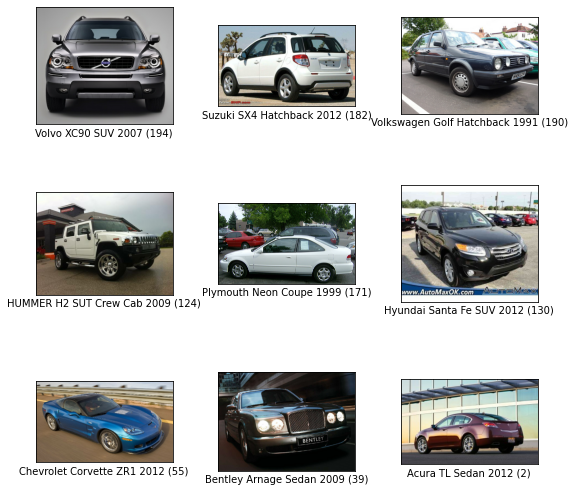

In [ ]:
fig = tfds.show_examples(cars_info, cars_ds_train)

Смотрим информацию о датасете.

In [ ]:
cars_info

tfds.core.DatasetInfo(
    name='cars196',
    version=2.0.0,
    description='The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.',
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    total_num_examples=16185,
    splits={
        'test': 8041,
        'train': 8144,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,
      title = {3D Object Representations for Fine-Grained Categorization},
      booktitle = {4th International IEEE Worksh

Имеем 196 классов и необходимость нормализовать данные.

In [ ]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_label = datapoint['label']

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)

  input_image = normalize(input_image)

  return input_image, input_label

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_label = datapoint['label']
  input_image = normalize(input_image)

  return input_image, input_label

In [ ]:
TRAIN_LENGTH = cars_info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
list_of_labels = cars_info.features['label'].names

In [ ]:
train = cars_ds_train.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = cars_ds_test.map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Функция позволяющая посмотреть на отнормированные данные

In [ ]:
def display(display_list, labels_list):
  plt.figure(figsize=(15, 15))

  title = ['Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(list_of_labels[labels_list[i].numpy()])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

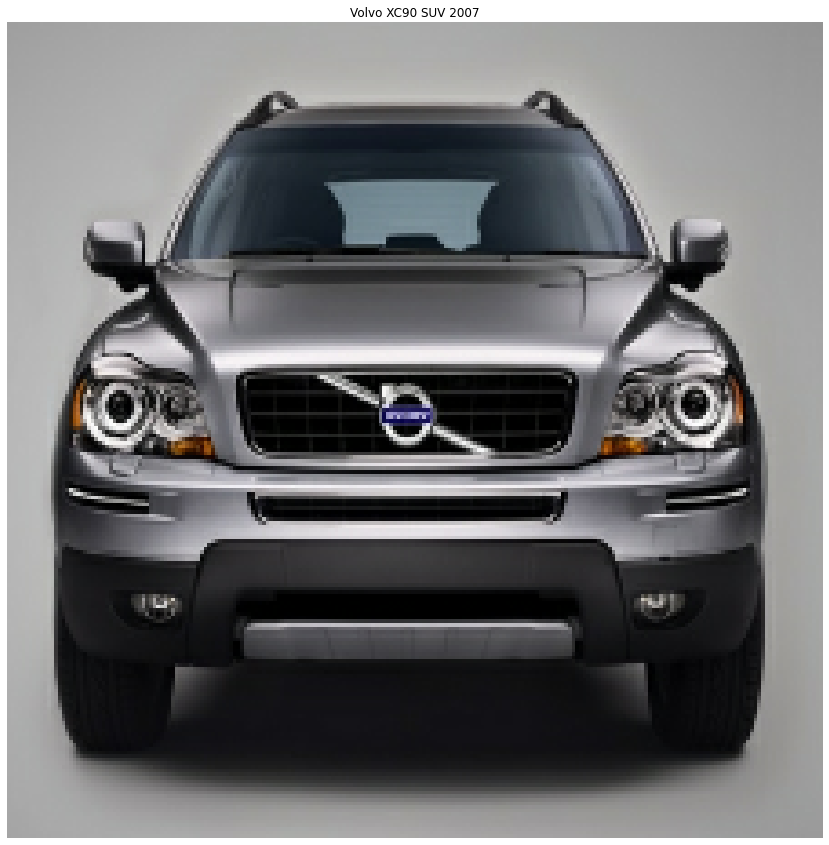

In [ ]:
for image, label in train.take(1):
  sample_image, sample_label = image, label
display([sample_image], [sample_label])

Обучем модель ResNet50. Модели больше большей размерности обочуть на GoogleColab не получается.

In [ ]:
model = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_shape=(224, 224, 3), classes=196)

In [ ]:
#model_101 = tf.keras.applications.ResNet101(
#    include_top=False, weights=None, input_shape=(224, 224, 3), pooling='max', classes=196)

In [ ]:
#tf.keras.utils.plot_model(model_101, show_shapes=True)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = cars_info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(test_dataset.take(1))

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20
127/127 [==============================] - 6256s 49s/step - loss: 5.7250 - accuracy: 0.0066
Epoch 2/20
127/127 [==============================] - 6230s 49s/step - loss: 5.2633 - accuracy: 0.0095
Epoch 3/20
127/127 [==============================] - 6211s 49s/step - loss: 5.1613 - accuracy: 0.0141
Epoch 4/20
127/127 [==============================] - 6223s 49s/step - loss: 5.0726 - accuracy: 0.0186
Epoch 5/20
127/127 [==============================] - 6252s 49s/step - loss: 4.9936 - accuracy: 0.0255
Epoch 6/20
 18/127 [===>..........................] - ETA: 1:22:17 - loss: 4.9667 - accuracy: 0.0290

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Считат ~1.5 часа один epoch. Попытка обучить ResNet модель на GoogleColab не удалась